# Model module tutorial

This tutorial is a part of Model module guide. Here, we explore how you can use the Matconvnet wrapper to use your Matconvnet deep learning models in the benchmark.

In [1]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import sys
sys.path.insert(0,'../../')

In [2]:
# Python packages
import gc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# Matlab engine
try:
    import matlab.engine
except ImportError as err:
    print(err)

# Matlab engine
eng = matlab.engine.start_matlab()

In [4]:
# Benchmark modules
from OpenDenoising import data
from OpenDenoising import model
from OpenDenoising import evaluation

Using TensorFlow backend.
W0902 11:21:43.065245 140606146111296 deprecation_wrapper.py:119] From ../../model/tf_model.py:15: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [5]:
def display_results(clean_imgs, noisy_imgs, rest_images, name):
    """Display denoising results."""
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    
    plt.suptitle("Denoising results using {}".format(name))

    for i in range(5):
        axes[i, 0].imshow(np.squeeze(clean_imgs[i]), cmap="gray")
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Ground-Truth")

        axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Noised Image")

        axes[i, 2].imshow(np.squeeze(rest_imgs[i]), cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Restored Images")

In [6]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

In [7]:
# Training images generator
train_generator = data.DatasetFactory.create(path="../../tmp//BSDS500/Train",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             preprocessing=[partial(data.gen_patches, patch_size=40),
                                                            partial(data.dncnn_augmentation, aug_times=1)],
                                             name="BSDS_Train")

In [8]:
# Validation images generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             name="BSDS_Valid")

# Matconvnet model <a class="anchor" id="Matconvnet-model"></a> 
---

# Navigation
---

* [Matconvnet Model](#Matconvnet-model)
    * [Charging a model](#matconvnet-charging-a-model)
        * [SimpleNN](#simplenn)
        * [DAGNN](#dagnn)

Matconvnet models are Deep Learning models based on the [Matconvnet toolbox](http://www.vlfeat.org/matconvnet/) for Matlab. These models may be used in Python through Matlab's Python engine, which enables the users to run matlab code inside Python.

Although possible to run, the implementation of Matlab's numerical types is not always straightforward, hence, every arithimetic calculation is done through Matlab functions. Here we go through two examples of Deep Neural networks implemented using Matconvnet's Simple and DAGNN classes, [DnCNN](https://github.com/cszn/DnCNN) and [MWCNN](https://github.com/lpj0/MWCNN).

__Remark__ Matconvnet model's are only available for evaluation.

## Charging a model <a class="anchor" id="matconvnet-charging-a-model"></a> 

Following [Matconvnet's tutorial](http://www.vlfeat.org/matconvnet/matconvnet-manual.pdf), the Toolbox has two main wrappers,

* SimpleNN, a wrapper suitable for networks consisting of linear chains of computationalblocks.  It is largely implemented by thevl_simplennfunction (evaluation of the CNN and ofits derivatives), with a few other support functions such asvl_simplenn_move(moving theCNN between CPU and GPU) andvl_simplenn_display(obtain and/or print informationabout the CNN).
* DagNN wrapper, which is more complex than SimpleNN as it has to support arbitrary graphtopologies.  Its design is object oriented, with one class implementing each layer type.

In order to use your Matlab code along with our Benchmark, you will need to implement a "denoise" function, which is responsible for doing three main tasks,

1. Load the network architecture. This function reads a .mat file which contains the network architecture and its weights.
2. Move the network and the noisy input array to GPU (if GPU is enabled).
3. Perform denoising, by calling either __vl_simplenn__ (simplenn) or __net.eval__ (dagnn).
4. Pass the restored image array back to CPU, if GPU is enabled.

The "denoise" function should have "denoise" in its name (i.e. "DnCNN_denoise"), and should agree with the following convention:

```matlab
function image_restored = mynet_denoise(net_path, image, useGPU)
% Loading net
% Move net + arrays to GPU
% perform denoising
% Move result to CPU
end
```

### SimpleNN <a class="anchor" id="simplenn"></a> 

The SimpleNN wrapper class is well suited for linear chains of neural network layers. In order to construct the neural network object, you need to specify the path to a ".mat" file containing a pre-trained SimpleNN network. In our example, we consider a SimpleNN-based DnCNN taken from the [Github Repository](https://github.com/cszn/DnCNN) of DnCNN's paper. The model was trained to denoise images with $\sigma=25$ gaussian noise. In order to use the model, we propose the following Matlab function,

```Matlab
function [image_restored] = DnCNN_denoise(net_path, image, useGPU)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Given an image array, simplenn_denoise performs image denoising by     %
% loading a deep neural network architecture located on 'net_path'.      %
% Params:                                                                %
%   1) net_path: path to .m file containing the model.                   %
%   2) image: 2d float array containing the image                        %
%   3) useGPU: boolean defining if it will use GPU or not.               %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%% Load Network architecture
net_obj = load(net_path);               % Loads the network into the workspace
net = net_obj.net;                      % Gets the network from the network object in workspace
net = vl_simplenn_tidy(net);            % Fixes the network in case of version incompatibilities

%% Move net to GPU
if useGPU == 1
    net = vl_simplenn_move(net, 'gpu'); % Pass net to GPU
    image = gpuArray(image);            % Pass image to GPU
end

%% Perform denoising
res = vl_simplenn(net, image, [], [], ...         % vl_simplenn is the function used for to evaluate the network
                  'conserveMemory', true, ...     % on the input 'image'. 'conserveMemory' parameter deletes all
                  'mode', 'test');                % intermediate responses. 'mode' sets BatchNorm to test mode.
image_restored = res(end).x;                      % Gets the output of last layer.

%% Move result to CPU
if useGPU == 1
	image = gather(image);                        % Gets image array from GPU.
    image_restored = gather(image_restored);      % Gets output array from GPU.
end

image_restored = single(image - image_restored);  % In DnCNN, the network is used to predict the noise rather
                                                  % than the image itself.

end
```

Considering such function, which needs to be defined in the same folder as the model weight + architecture ".mat" file, you only need to pass the path to the ".mat" file. Being so, consider the files on "./Additional Files/Matconvnet Models/",

In [9]:
model_path = "/home/efernand/repos/Summer_Internship_2019/Code/examples" \
             "/Jupyter Notebooks/Additional Files/Matconvnet Models/simplenn/dncnn.mat"

In [10]:
matconvnet_ex1 = model.MatconvnetModel(model_name="DnCNN")
matconvnet_ex1.charge_model(model_path=model_path)

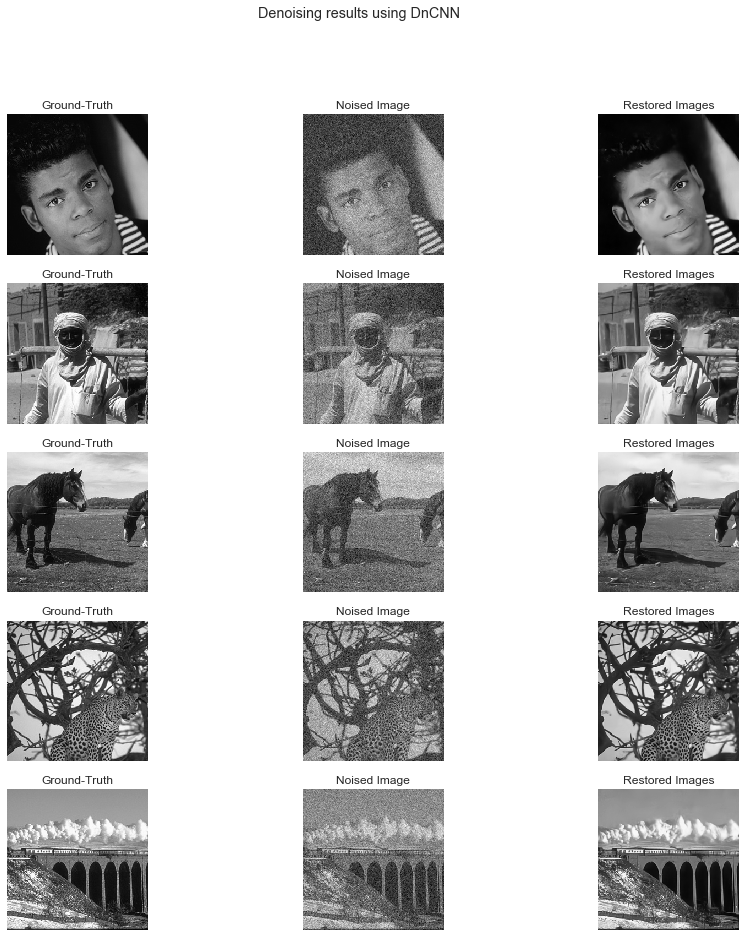

In [11]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = matconvnet_ex1(noisy_imgs)
# Display results
display_results(clean_imgs, noisy_imgs, rest_imgs, str(matconvnet_ex1))

#### DAGNN <a class="anchor" id="dagnn"></a> 

DAGNN networks represents a wrapper for richer kinds of networks. For our DAGNN network, we take [MWCNN](https://github.com/lpj0/MWCNN) as example, which rely on custom DWT (Discrete Wavelet Transform)/ IDWT(Inverse Discrete Wavelet Transform) layers to compute its output.

The process to compute the network's output is the same, except from a few syntax changes while loading the model, as follows,

```Matlab
function [image_restored] = MWCNN_denoise(net_path, image, useGPU)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Given an image array, mwcnn performs image denoising by loading        %
% a deep neural network architecture located on 'net_path'.              %
% Params:                                                                %
%   1) net_path: path to .m file containing the model.                   %
%   2) image: 2d float array containing the image                        %
%   3) useGPU: boolean defining if it will use GPU or not.               %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%% Load Network architecture
net_obj = load(net_path);                               % Loads network object into workspace
net = net_obj.net;                                      % Gets network from network object
net = dagnn.DagNN.loadobj(net);                         % Loads the network into the wrapper
net.removeLayer('objective');                           % Remove objective layer (only needed for training)
out_idx = net.getVarIndex('prediction');                % Get prediction layer
net.vars(net.getVarIndex('prediction')).precious = 1;   % Fix network variable values.
net.mode = 'test';                                      % Set network to test model.

%% Preprocess image
% Scale images between -2 and +2.
% OBS: needed only for MWCNN.
input = image * 4 - 2; 

%% Move net to GPU
if useGPU == 1
    net.move('gpu');    % Pass net to GPU
    input = gpuArray(input);  % Pass image to GPU
end

%% Computes output
net.eval({'input', input});
image_restored = gather(...
    squeeze(...
        gather(...
            net.vars(out_idx).value + 2 ...
        ) / 4 ...
    )...
);

end

```

In [12]:
model_path = "/home/efernand/repos/Summer_Internship_2019/Code/examples" \
             "/Jupyter Notebooks/Additional Files/Matconvnet Models/dagnn/mwcnn.mat"

In [13]:
matconvnet_ex2 = model.MatconvnetModel(model_name="mwcnn")
matconvnet_ex2.charge_model(model_path=model_path)

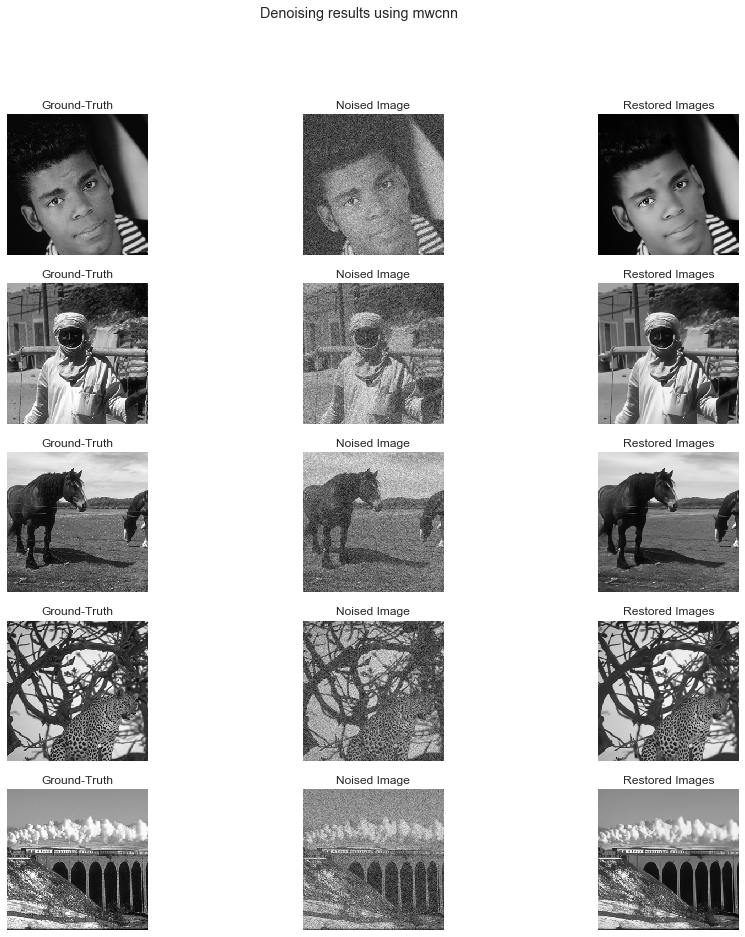

In [14]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = matconvnet_ex2(noisy_imgs)
# Display results
display_results(clean_imgs, noisy_imgs, rest_imgs, str(matconvnet_ex2))